In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_curve, auc, f1_score
from sklearn.metrics import roc_curve, auc, f1_score
from datetime import datetime
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import plot_confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:

from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv('data/raw/raw_data_for_pipeline_v2.csv')
df.head(1)

,age,sex,race,marital_status,relationship_label,relationship,functional_weight,education,education_num,workclass,occupation,capital_gain,capital_loss,hours_per_week,native_country,country_name,target
0,66,Male,White,Married-civ-spouse,0,Husband,36364,HS-grad,9,Local-gov,Craft-repair,0,2267,40,39,United-States,0


In [4]:
summary = pd.read_csv('my_summary_outlier_mask.csv')

#  Label Encoder for all categorical features

## RobustScaler

In [5]:
le = LabelEncoder()
column_for_label = ['sex','race','marital_status','relationship','education','workclass',
                    'occupation','country_name']
for c in column_for_label:
    df[c] = le.fit_transform(df[c]) # transorming feature
df.head(3)

,age,sex,race,marital_status,relationship_label,relationship,functional_weight,education,education_num,workclass,occupation,capital_gain,capital_loss,hours_per_week,native_country,country_name,target
0,66,1,4,2,0,0,36364,11,9,2,3,0,2267,40,39,39,0
1,32,1,4,4,1,1,142675,11,9,4,3,0,0,40,39,39,0
2,28,0,2,4,1,1,161087,15,10,4,4,0,0,45,23,23,0


In [6]:
columns_to_drop = ['relationship_label', 'education_num','native_country']
df.drop(columns_to_drop, axis = 1, inplace = True)
df.head(1)

,age,sex,race,marital_status,relationship,functional_weight,education,workclass,occupation,capital_gain,capital_loss,hours_per_week,country_name,target
0,66,1,4,2,0,36364,11,2,3,0,2267,40,39,0


In [7]:
data_features_rs = df.iloc[:, : ]

scaler = RobustScaler()
scaled_df = pd.DataFrame(
    data=scaler.fit_transform(data_features_rs), 
    columns=data_features_rs.columns
)

In [8]:
scaled_df.head(3)

,age,sex,race,marital_status,relationship,functional_weight,education,workclass,occupation,capital_gain,capital_loss,hours_per_week,country_name,target
0,1.45,0.0,0.0,0.0,-0.333333,-1.191062,0.000000,-2.0,-0.571429,0.0,2267.0,0.0,0.0,0.0
1,-0.25,0.0,0.0,1.0,0.000000,-0.299206,0.000000,0.0,-0.571429,0.0,0.0,0.0,0.0,0.0
2,-0.45,-1.0,-2.0,1.0,0.000000,-0.144746,1.333333,0.0,-0.428571,0.0,0.0,1.0,-16.0,0.0


In [9]:
summary.head(1)

,Unnamed: 0,std,iqr,euclid,cityblock,svm,isolation
0,0,1,1,0,0,1,1


In [10]:
summary.shape, df.shape

((32235, 7), (32235, 14))

In [11]:
summary.drop('Unnamed: 0', axis = 1, inplace = True)

In [12]:
summary.sum(axis=1).value_counts()

1    11621
0    10975
2     4701
3     3101
4     1272
5      384
6      181
dtype: int64

###  Threshold for the number of filters for cleaning outliers ( if threshold  == 6 , its Full Dataset )

In [13]:
mask_clear_all = summary.sum(axis=1) < 7

In [14]:
df_clear = scaled_df[mask_clear_all]

In [15]:
df_clear.shape

(32235, 14)

## DATA for Models

In [16]:
X_df = df_clear.drop(['target'], axis = 1)
y_df = df_clear['target']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X_df,
    y_df,
    test_size=0.20,
    random_state=42)

In [18]:
X_df.shape

(32235, 13)

In [19]:
#Instantiate the classifiers
clf_logreg = LogisticRegression()
clf_tree = DecisionTreeClassifier()
clf_knn =  KNeighborsClassifier()
clf_svc = SVC()
clf_forest = RandomForestClassifier()
clf_ada = AdaBoostClassifier()
clf_bagging = BaggingClassifier()
clf_xgb = XGBClassifier()

In [20]:
models = {clf_logreg:'LogisticRegression',  
            clf_tree: 'DecisionTreeClassifier',
            clf_knn: 'KNN',
            clf_forest: 'RandomForestClassifier',
            clf_ada: 'AdaBoostClassifier',
            clf_bagging: 'BaggingClassifier',
            clf_xgb: 'XGBoost',
            clf_svc: 'SVM'}

classifiers = models.values()

In [21]:
score_model = []
time_model_fit = []
time_model_predict = []
# time_model_predict = []
for model,value in models.items():
    start_time = datetime.now()    
    model.fit(X_train,y_train)
    elapsed_time = datetime.now() - start_time
    time_model_fit.append(elapsed_time)
    start_time = datetime.now()
    y_pred = model.predict(X_test)
    elapsed_time = datetime.now() - start_time
    time_model_predict.append(elapsed_time)
    score = accuracy_score(y_test,y_pred)
    score_model.append(score)        

In [22]:
about_models = pd.DataFrame(score_model, index = classifiers,
            columns = ['Accuracy Score', ])
about_models['Time to Fit'] = time_model_fit
about_models['Time to Predict'] = time_model_predict
about_models.sort_values(by = 'Accuracy Score', ascending = False)

,Accuracy Score,Time to Fit,Time to Predict
XGBoost,0.856678,00:00:01.915071,00:00:00.014764
AdaBoostClassifier,0.851714,00:00:00.596154,00:00:00.028693
RandomForestClassifier,0.846440,00:00:00.180140,00:00:00.010935
BaggingClassifier,0.835738,00:00:00.560307,00:00:00.010877
KNN,0.832946,00:00:00.626385,00:00:01.125327
SVM,0.828758,00:00:12.971654,00:00:01.376729
DecisionTreeClassifier,0.807973,00:00:00.094096,00:00:00.001729
LogisticRegression,0.795874,00:00:00.110952,00:00:00.002054


## Choice  3 Best Models for our Data

In [23]:
models_new = {clf_xgb: 'XGBoost',        
              clf_ada: 'AdaBoostClassifier',
              clf_forest: 'RandomForestClassifier',}

classifiers_new = models_new.values()

+++++++++++++++++++++++  XGBoost  ++++++++++++++++++++ :
 - accuracy_score:  0.857
 - f1_score:  0.666
----------------------------
 - ROC AUC _score:  0.914
----------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91      4843
         1.0       0.79      0.57      0.67      1604

    accuracy                           0.86      6447
   macro avg       0.83      0.76      0.79      6447
weighted avg       0.85      0.86      0.85      6447



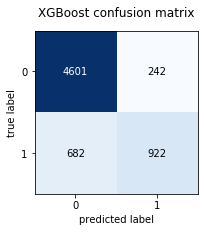

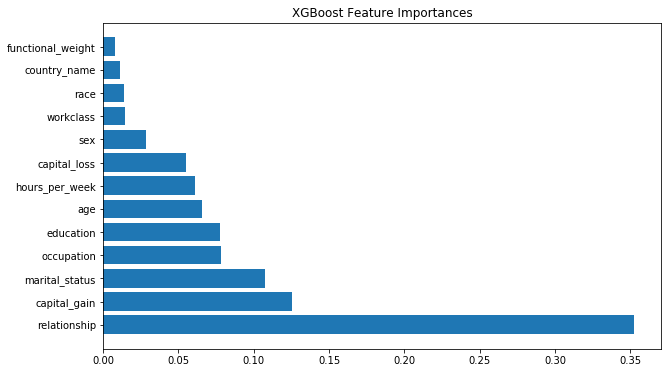

+++++++++++++++++++++++  AdaBoostClassifier  ++++++++++++++++++++ :
 - accuracy_score:  0.852
 - f1_score:  0.666
----------------------------
 - ROC AUC _score:  0.908
----------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90      4843
         1.0       0.76      0.60      0.67      1604

    accuracy                           0.85      6447
   macro avg       0.82      0.77      0.79      6447
weighted avg       0.85      0.85      0.85      6447



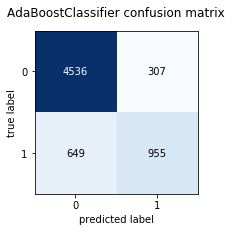

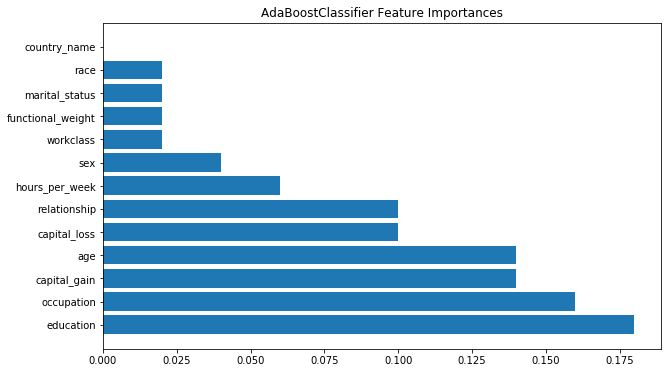

+++++++++++++++++++++++  RandomForestClassifier  ++++++++++++++++++++ :
 - accuracy_score:  0.841
 - f1_score:  0.640
----------------------------
 - ROC AUC _score:  0.875
----------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90      4843
         1.0       0.74      0.57      0.64      1604

    accuracy                           0.84      6447
   macro avg       0.80      0.75      0.77      6447
weighted avg       0.83      0.84      0.83      6447



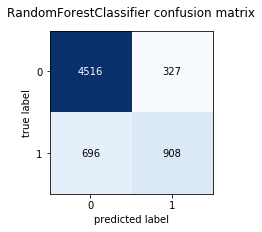

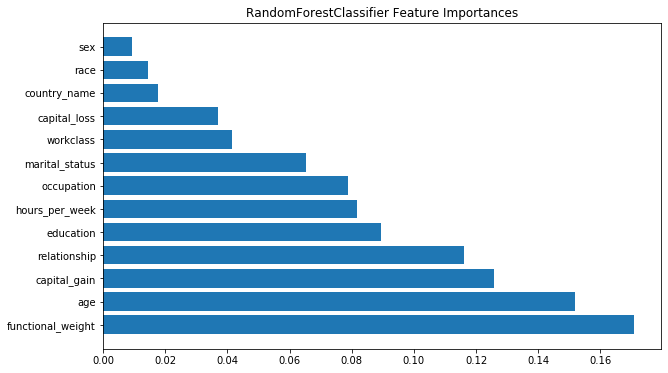

In [24]:
mean_score = []
std_score = []
time_best_model_fit = []

for model,value in models_new.items():
        
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    # calculate the AUC
    y_pred_prob = model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred_prob[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    print(f"+++++++++++++++++++++++  {value}  ++++++++++++++++++++ :")    
    print(f" - accuracy_score: {accuracy_score(y_test, y_pred): .3f}")
    print(f" - f1_score: {f1_score(y_test, y_pred): .3f}")
    print('----------------------------')
    print(f" - ROC AUC _score: {roc_auc: .3f}")
    print('----------------------------')
    print(classification_report(y_test, y_pred))
    
    CM = confusion_matrix(y_test, y_pred)
    from mlxtend.plotting import plot_confusion_matrix
    fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(3, 3))
    plt.title(f'{value} confusion matrix')
    plt.show()
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1] 
    plt.figure(figsize=(10,6))
    plt.barh(X_train.columns[indices], importances[indices])
    plt.title(f'{value} Feature Importances')
    plt.show()

    start_time = datetime.now()
    scores = cross_val_score(model,X_train,y_train,scoring = 'accuracy',cv = 10)
    elapsed_time = datetime.now() - start_time
    mean_score.append(scores.mean())
    std_score.append(scores.std())
    time_best_model_fit.append(elapsed_time)

### Analize Cross Validation

In [25]:
cross_val_best_models = pd.DataFrame(mean_score, index = classifiers_new,
            columns = ['Accuracy Score', ]).round(3)
cross_val_best_models['STD of Accuracy'] = std_score
cross_val_best_models['Time to Fit'] = time_best_model_fit
cross_val_best_models.sort_values(by = 'Accuracy Score', ascending = False)

,Accuracy Score,STD of Accuracy,Time to Fit
XGBoost,0.868,0.007218,00:00:17.396107
AdaBoostClassifier,0.862,0.007304,00:00:05.354136
RandomForestClassifier,0.853,0.006406,00:00:01.754884


### AdaBoost  Tuning hyperparameters

#### Prepare Data for AdaBoost

In [26]:
X_train_ada = X_train.drop(['country_name'], axis = 1)
X_test_ada = X_test.drop(['country_name'], axis = 1)

In [27]:
clf_ada.fit(X_train,y_train)

y_pred = clf_ada.predict(X_test)
# calculate the AUC
y_pred_prob = clf_ada.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred_prob[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

print(f"+++++++++++++++++++++++  {value}  ++++++++++++++++++++ :")    
print(f" - accuracy_score: {accuracy_score(y_test, y_pred): .3f}")
print(f" - f1_score: {f1_score(y_test, y_pred): .3f}")
print('----------------------------')
print(f" - ROC AUC _score: {roc_auc: .3f}")
print('----------------------------')
print(classification_report(y_test, y_pred))

+++++++++++++++++++++++  RandomForestClassifier  ++++++++++++++++++++ :
 - accuracy_score:  0.852
 - f1_score:  0.666
----------------------------
 - ROC AUC _score:  0.908
----------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90      4843
         1.0       0.76      0.60      0.67      1604

    accuracy                           0.85      6447
   macro avg       0.82      0.77      0.79      6447
weighted avg       0.85      0.85      0.85      6447



#### After drop column 'country_name' dont change 'accuracy score', 'f1_score' . For AdaBost no any 
####  information in this column.

In [28]:
parameters = {
    'n_estimators' : [195, 200, 215, 210],
    'learning_rate': [1.7, 1.75]}

In [29]:
# clf_ada = AdaBoostClassifier(
#     DecisionTreeClassifier(max_depth = 'max_depth'),
#     n_estimators = 'n_estimators',
#     learning_rate = 'learning_rate')

base_model = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1))
gs_model = GridSearchCV(
    base_model, 
    parameters, 
    verbose=False,
    scoring='roc_auc')

In [30]:
gs_model.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=1,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
                                                                              

In [31]:
gs_model.best_score_

0.9251278603590645

In [32]:
gs_model.best_params_

{'learning_rate': 1.7, 'n_estimators': 210}

In [33]:
gs_model.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

Sklearn AdaBoost Classifier :
----------------------------
 - ROC AUC _score:  0.921
----------------------------
 - accuracy_score:  0.862
 - f1_score:  0.692
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91      4843
         1.0       0.78      0.62      0.69      1604

    accuracy                           0.86      6447
   macro avg       0.83      0.78      0.80      6447
weighted avg       0.86      0.86      0.86      6447



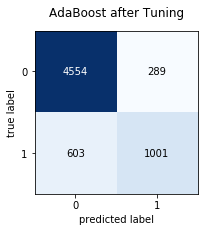

In [34]:
# accuracy score for model with GS

y_pred_gs = gs_model.predict(X_test)

# calculate the AUC
y_pred_prob_gs = gs_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred_prob_gs[:,1], pos_label=1)

roc_auc = auc(fpr, tpr)

print("Sklearn AdaBoost Classifier :")
print('----------------------------')
print(f" - ROC AUC _score: {roc_auc: .3f}")
print('----------------------------')
print(f" - accuracy_score: {accuracy_score(y_test, y_pred_gs): .3f}")
print(f" - f1_score: {f1_score(y_test, y_pred_gs): .3f}")
print(classification_report(y_test, y_pred_gs))
    
CM = confusion_matrix(y_test, y_pred_gs)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(3, 3))
plt.title('AdaBoost after Tuning')
plt.show()

## Summary

### In conclusion, it can be noted that with the constant 'accuracy', the 'recall  1 class' 
###  and 'ROC AUC' increased, this positively characterizes our model.